# 03. XAI

Aplicar técnicas de explicabilidad (Tabular Methods) vistas en la teoría al modelo de Credit Risk.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import shap
import lime
from alepython import ale_plot # pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

from sklearn.inspection import permutation_importance, PartialDependenceDisplay


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

REPORT_IMG_DIR = "../report/images"
os.makedirs(REPORT_IMG_DIR, exist_ok=True)

## 1. Cargar Recursos

In [29]:
PROCESSED_DIR = "../data/processed"
MODELS_DIR = "../models"

train_df = pd.read_csv(os.path.join(PROCESSED_DIR, "train.csv"))
val_df = pd.read_csv(os.path.join(PROCESSED_DIR, "val.csv"))

X_train = train_df.drop(columns=['Target'])
y_train = train_df['Target']
X_val = val_df.drop(columns=['Target'])
y_val = val_df['Target']
model_pipeline = joblib.load(os.path.join(MODELS_DIR, "rf_model.joblib"))
feature_names_out = joblib.load(os.path.join(MODELS_DIR, "feature_names.joblib"))
feature_names = list(feature_names_out)
rf_model = model_pipeline.named_steps['classifier']
preprocessor = model_pipeline.named_steps['preprocessor']

## 2. Permutation Feature Importance (PFI)

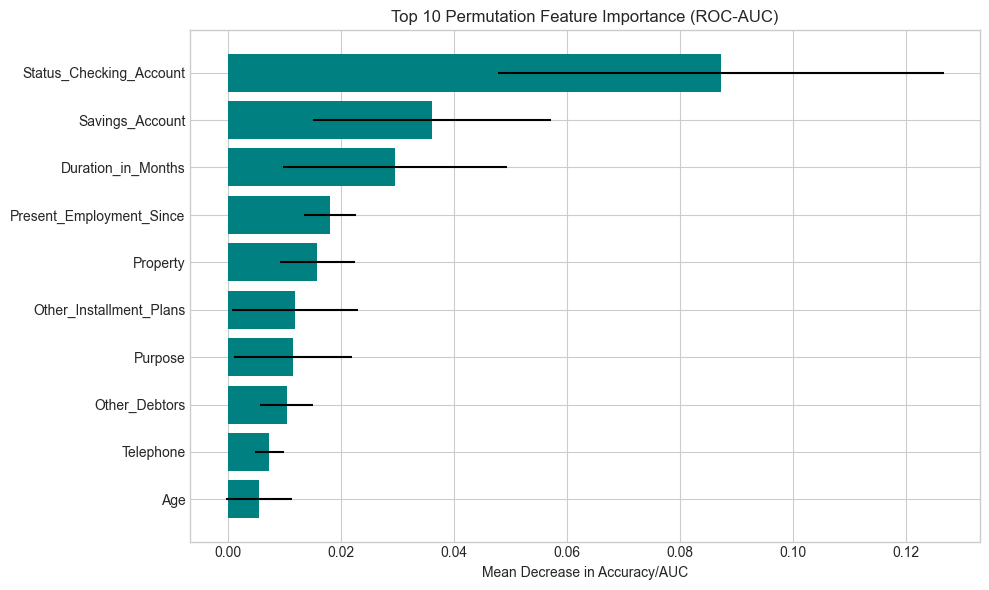

In [30]:
pfi = permutation_importance(
    model_pipeline, X_val, y_val, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1, 
    scoring='roc_auc'
)
pfi_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': pfi.importances_mean,
    'Std': pfi.importances_std
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
top_pfi = pfi_df.head(10)
plt.barh(top_pfi['Feature'], top_pfi['Importance'], xerr=top_pfi['Std'], color='teal', align='center')
plt.gca().invert_yaxis()
plt.title("Top 10 Permutation Feature Importance (ROC-AUC)")
plt.xlabel("Mean Decrease in Accuracy/AUC")
plt.tight_layout()
plt.savefig(os.path.join(REPORT_IMG_DIR, "05_pfi.png"), dpi=300)
plt.show()

## 3. Partial Dependence Plots (PDP) y ALE
Elegimos las features más importantes según PFI para analizar su efecto marginal. Probablemente `Duration_in_Months` y `Status_Checking_Account_A14` (o similar).

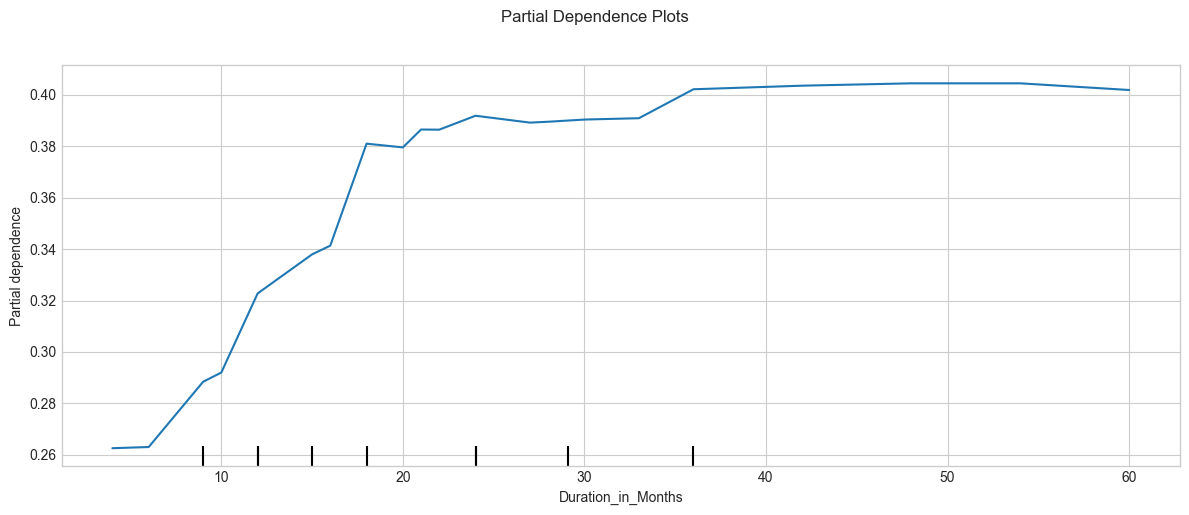

In [ ]:
features_to_plot = ['Duration_in_Months']
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(
    model_pipeline, 
    X_val, 
    features_to_plot, 
    ax=ax, 
    kind='average', 
    grid_resolution=50
)
plt.suptitle("Partial Dependence Plots", y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(REPORT_IMG_DIR, "06_ale_pdp_proxy.png"), dpi=300)
plt.show()

### ALE Plots

<Figure size 800x500 with 0 Axes>

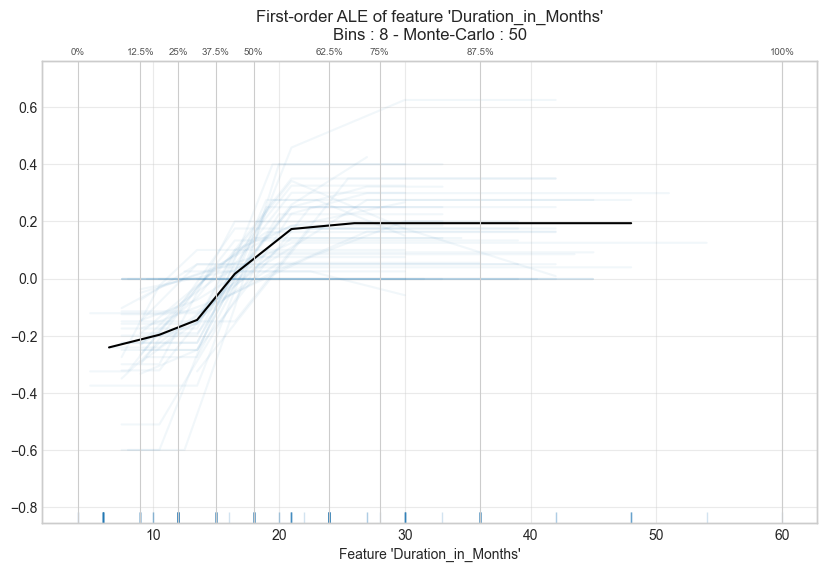

<Axes: title={'center': "First-order ALE of feature 'Duration_in_Months'\nBins : 8 - Monte-Carlo : 50"}, xlabel="Feature 'Duration_in_Months'">

In [32]:
def predict_func(X_numpy):
    X_df = pd.DataFrame(X_numpy, columns=X_train.columns)
    return model_pipeline.predict_proba(X_df)[:, 1]

plt.figure(figsize=(8, 5))
ale_plot(
    model_pipeline, 
    X_val, 
    ["Duration_in_Months"], 
    monte_carlo=True
)

## 4. SHAP (Global)

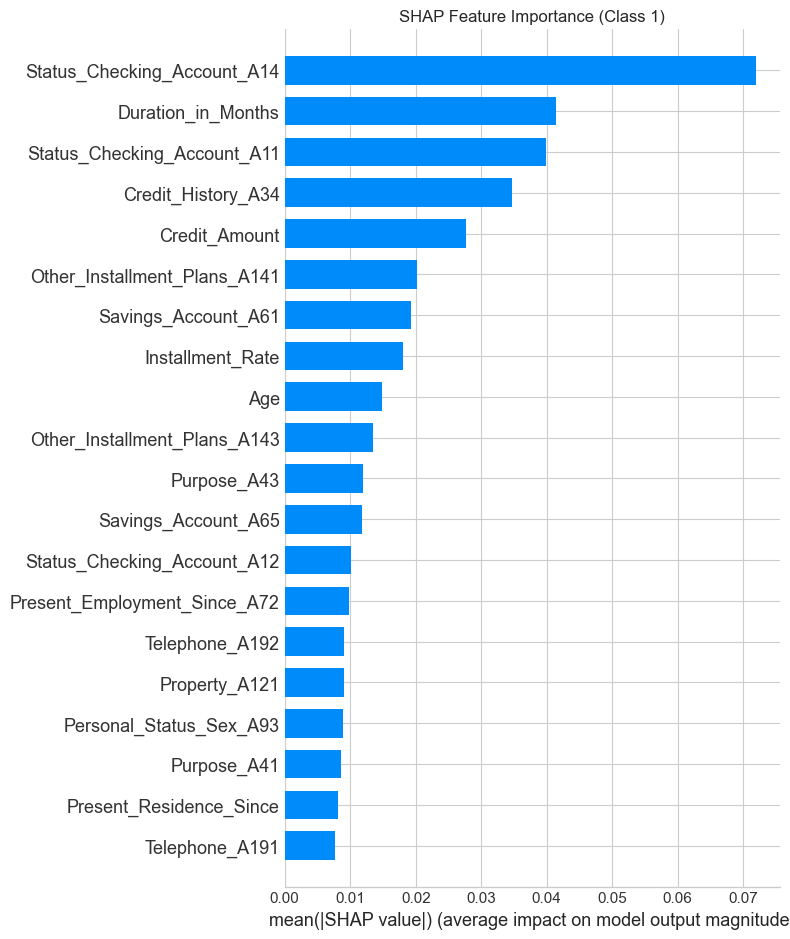

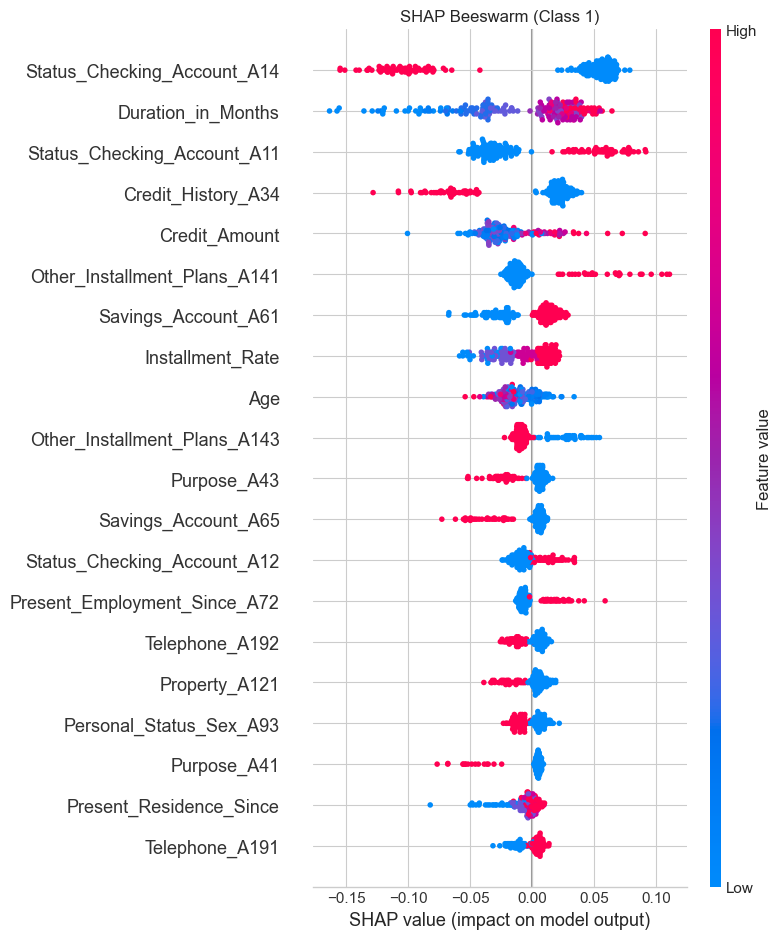

In [33]:
def _to_dense(X):
    return X.toarray() if hasattr(X, 'toarray') else np.asarray(X)

X_val_trans = preprocessor.transform(X_val)
X_val_trans_dense = _to_dense(X_val_trans)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_val_trans_dense)
shap_values_c1 = shap_values[:, :, 1]

shap.summary_plot(shap_values_c1, X_val_trans_dense, feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Class 1)")
plt.tight_layout()
plt.savefig(os.path.join(REPORT_IMG_DIR, "07_shap_importance.png"), dpi=300)
plt.show()
shap.summary_plot(shap_values_c1, X_val_trans_dense, feature_names=feature_names, plot_type="dot", show=False)
plt.title("SHAP Beeswarm (Class 1)")
plt.tight_layout()
plt.savefig(os.path.join(REPORT_IMG_DIR, "07_shap_beeswarm.png"), dpi=300)
plt.show()


## 5. Explicación Local (Instancia Específica)

Analizando instancia índice 179 con probabilidad 0.7806


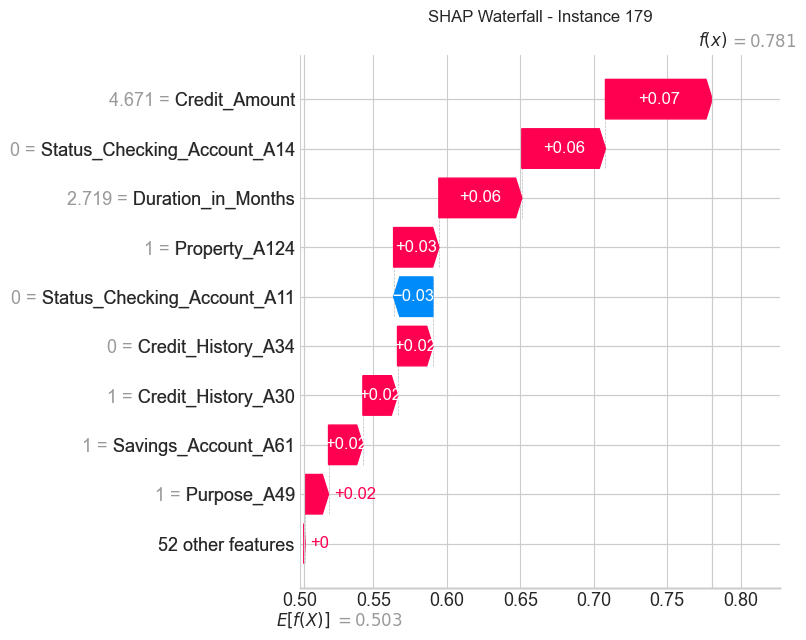

In [34]:
probs = model_pipeline.predict_proba(X_val)[:, 1]
high_risk_idx = np.argmax(probs)
print(f"Analizando instancia índice {high_risk_idx} con probabilidad {probs[high_risk_idx]:.4f}")

instance_raw = X_val.iloc[[high_risk_idx]]
instance_trans = preprocessor.transform(instance_raw)
instance_trans_dense = _to_dense(instance_trans)
shap_values_single = explainer.shap_values(instance_trans_dense)

shap_val_single = shap_values_single[0, :, 1]
expected_val = explainer.expected_value[1]

plt.figure()
exp_obj = shap.Explanation(
    values=shap_val_single,
    base_values=expected_val,
    data=instance_trans_dense[0],
    feature_names=feature_names
)
shap.plots.waterfall(exp_obj, show=False, max_display=10)
plt.title(f"SHAP Waterfall - Instance {high_risk_idx}")
plt.tight_layout()
plt.savefig(os.path.join(REPORT_IMG_DIR, "08_shap_waterfall.png"), dpi=300)
plt.show()

### LIME

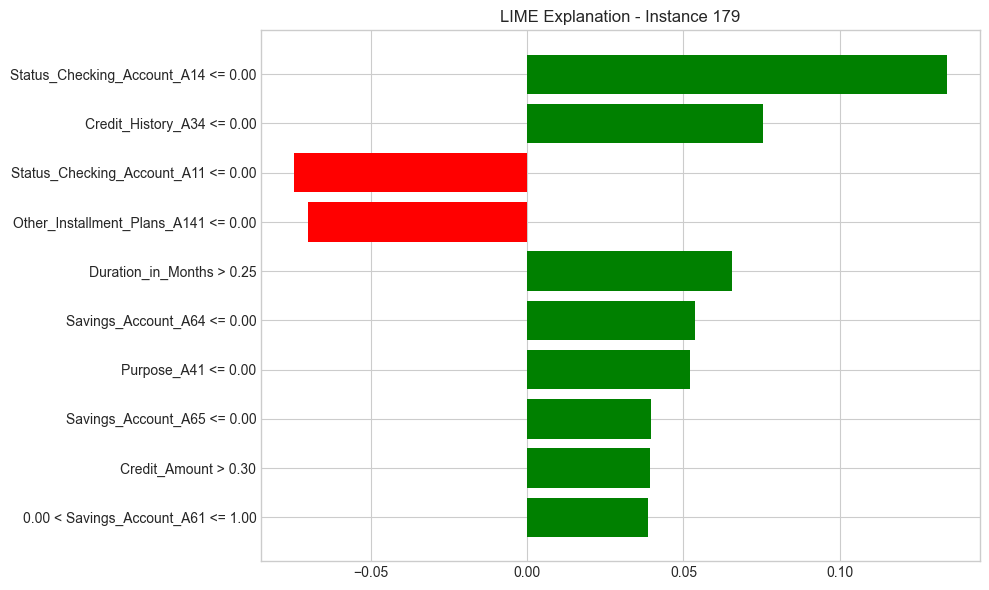

In [35]:
X_train_trans = preprocessor.transform(X_train)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_trans,
    feature_names=feature_names,
    class_names=['Class 0', 'Class 1'],
    mode='classification',
    verbose=False
)
predict_fn_rf = lambda x: rf_model.predict_proba(x)
exp_lime = lime_explainer.explain_instance(
    data_row=instance_trans[0],
    predict_fn=predict_fn_rf,
    num_features=10
)

fig = exp_lime.as_pyplot_figure()
plt.title(f"LIME Explanation - Instance {high_risk_idx}")
plt.tight_layout()
plt.savefig(os.path.join(REPORT_IMG_DIR, "09_lime.png"), dpi=300)
plt.show()